# Tarea 1 - Redes densas
## Eduardo García Alarcón

### 2. Retropropagación en red densa

Programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria presuponiendo una red densa con dos capas ocultas. Las neuronas de las capas ocultas cuentan con una función de activasión ReLU, definida por $$ ReLU(x) = máx(0,z)$$

Por su parte, la capa de salida está compuesta por una sola neurona logística.

Para el entrenamiento minimiza el promedio de la función de pérdida de entropía cruzada binaria: 
$$
ECB(\bold{y}, \bold{\hat y}) = -\frac{1}{n} \sum_{i=1}^n \big[ y^{(i)} log \big(\hat y^{(i)}\big) + \big(1-y^{(i)}\big) log\big(1-\hat y^{(i)}\big)\big]
$$

Entrena la red mediante descenso por gradiente y el algoritmo de retropropagación de errores.

Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena y evalúa la red en algún problema de clasifiación no lineal. Compara el comportamiento del entrenamiento de esta red con una en la que las neuronas de las capas ocultas tienen una función de activasión logística y en la que la función de pérdida no se promedia. 

In [1]:
# Bilbiotecas
import numpy as np
# definimos la semilla
np.random.seed(42)

### Definimos la función de ReLU y su derivada

In [2]:
def relu(z):
  return np.maximum([0.0], z)

In [3]:
def derivada_relu(x):
  return x > 0

De Igual manera la sigmoide

In [4]:
def sigmoide(z):
  return 1 / (1 + np.exp(-z))

In [5]:
def derivada_sigmoide(x):
  s = sigmoide(x)
  return s * (1.0 - s)

### Definimos la función de Entropía Cruzada Binaria

In [6]:
def entropia_cruzada_binaria(y, p):
  # Para evitar divisiones entre 0
  p[p == 0] = np.nextafter(0., 1.)
  p[p == 1] = np.nextafter(1., 0.)
  
  return -( np.log( p[y==1] ).sum() + np.log(1 - p[y==0]).sum() )

#### Y definimos al exactitud

In [7]:
def exactitud(y, y_hat):
  return (y == y_hat).mean() * 100

#### Propagación hacia adelante

La red está conformada por 3 capas (2 ocultas y 1 salida); por lo que tenemos el siguiente sistema de ecuaciones:

$$\mathbf{A}^{\{1\}} = \mathbf{X}\\$$
$$\mathbf{Z}^{\{2\}} =  \mathbf{A}^{(1)} \cdot \mathbf{W}^{\{1\}} + \mathbf{b}^{\{1\}}\\$$
$$\mathbf{A}^{\{2\}} =  ReLU(\mathbf{Z}^{\{2\}}) \\$$
$$\mathbf{Z}^{\{3\}} =  \mathbf{A}^{\{2\}} \mathbf{W}^{\{2\}}  + \mathbf{b}^{\{2\}}\\$$
$$\mathbf{A}^{\{3\}} =  ReLU(\mathbf{Z}^{\{3\}})\\$$
$$\mathbf{Z}^{\{4\}} =  \mathbf{A}^{\{3\}} \mathbf{W}^{\{3\}}  + \mathbf{b}^{\{3\}}\\$$
$$\mathbf{A}^{\{4\}} =  \sigma(\mathbf{Z}^{\{4\}})\\$$
$$\mathbf{\hat{y}} = \mathbf{A}^{\{4\}}\\$$
		

In [8]:
def hacia_adelante(X, W1, b1, W2, b2, W3, b3):
  # Nos saltamos la declaración de A1 porque sería un desperdicio
  # print(f'{X.shape = }, {W1.shape = }, {b1.shape = }')
  Z2 = X @ W1 + b1
  A2 = relu(Z2)
  Z3 = A2 @ W2 + b2
  A3 = relu(Z3)
  Z4 = A3 @ W3 + b3
  y_hat = sigmoide(Z4)
  return Z2, A2, Z3, A3, Z4, y_hat

Utilizamos los lotes para facilitar el entrenamiento

In [9]:
from math import floor

In [10]:
def genera_lotes(X, y, t_lote=16):
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  perm = np.random.permutation(X.shape[0]) # se genera una permutación aleatoria
  Xperm = X[perm] # se reordenan las entradas y
  yperm = y[perm] # las entradas usando la permutación
  for lote in range(n_lotes): # se van tomando t_lote entradas y salidas
    Xlote = Xperm[lote * t_lote:(lote + 1) * t_lote]
    ylote = yperm[lote * t_lote:(lote + 1) * t_lote]
    yield Xlote, ylote

## Definimos el Descenso por gradiente por retropropagación de errores

En el caso de nuestra red, tenemos las siguientes ecuaciones

### Hacia atras
Usaremos el descenso por gradiente, entonces tenemos que calcular el gradiente de la función de pérdida de los pesos y sesgos en cada capa usando la retropropagación. 

Por lo que tendremos las siguientes ecuaciones:

$$
	\begin{split}
				\boldsymbol{\delta}^{\{4\}} & = \frac{1}{n}( \mathbf{\hat{y}}^{(i)} - \mathbf{y}^{(i)})\\
				\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{3\}}} & =  \mathbf{A}^{\{3\}\top} \cdot \boldsymbol{\delta}^{\{4\}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{3\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{4\}}_{j, :}\\
        \boldsymbol{\delta}^{\{3\}} & =  (\boldsymbol{\delta}^{\{4\}}\cdot \mathbf{W}^{\{3\}\top}) \odot \frac{\partial \mathbf{A}^{\{3\}}}{\partial \mathbf{Z}^{\{3\}}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{2\}}} & =  \mathbf{A}^{\{2\}\top} \cdot \boldsymbol{\delta}^{\{3\}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{2\}}} & =  \sum_{j=1}^{l}\boldsymbol{\delta}^{\{3\}}_{j, :}\\
        \boldsymbol{\delta}^{\{2\}} & =  (\boldsymbol{\delta}^{\{3\}}\cdot \mathbf{W}^{\{2\}\top}) \odot \frac{\partial \mathbf{A}^{\{2\}}}{\partial \mathbf{Z}^{\{2\}}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{1\}}} & =  \mathbf{X}^{\{1\}\top} \cdot \boldsymbol{\delta}^{\{2\}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{1\}}} & =  \sum_{j=1}^{l}\boldsymbol{\delta}^{\{2\}}_{j, :}\\
		\end{split}
  $$



In [11]:
def retropropagacion(X, y, alpha = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10, n_ocultas_2 = 10):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y V
  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
  # print(W1)
  b1 = np.zeros((1, n_ocultas))

  W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas_2)
  b2 = np.zeros((1, n_ocultas_2))

  W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas_2, 1)
  b3 = np.zeros((1, 1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))
  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote):
      Z2, A2, Z3, A3, Z4, y_hat = hacia_adelante(Xlote, W1, b1, W2, b2, W3, b3)

      # cálculo de gradientes para W3 y b3 por retropropagación
      dZ4 = y_hat - ylote
      dW3 = A3.T @ dZ4
      db3 = dZ4.sum(axis=0)
      
      # cálculo de gradientes para W2 y b2 por retropropagación
      dZ3 = (dZ4 @ W3.T) * derivada_relu(Z3)
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      dZ2 = (dZ3 @ W2.T) * derivada_relu(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # IMPORTANTE
      # la actualización de los parámetros
      # debe hacerse de forma simultánea
      W3 -= alpha * dW3
      b3 -= alpha * db3
      W2 -= alpha * dW2
      b2 -= alpha * db2
      W1 -= alpha * dW1
      b1 -= alpha * db1


      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria(ylote, y_hat)
      exactitudes[i] += exactitud(ylote, np.round(y_hat))

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, W3, b3, perdidas, exactitudes

### Pruebas

In [12]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

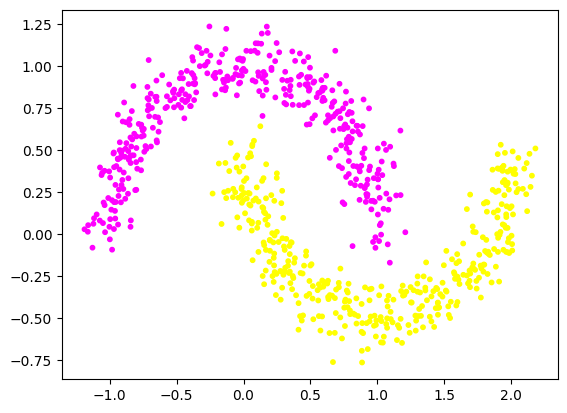

In [13]:
# Cargamos los datos
X, Y = make_moons(n_samples=800, noise=0.1, random_state=42)

plt.scatter(X[:, 0], X[:,1], c=Y, cmap=plt.cm.spring, s=10)
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [14]:
W1, b1, W2, b2, W3, b3, loss, acc = retropropagacion(X_train,
                                                    y_train[:, np.newaxis],
                                                    alpha=0.2, 
                                                    n_epocas=500, 
                                                    n_ocultas=10, n_ocultas_2=20, 
                                                    t_lote=4)

Epoch 0: Pérdida = 1.3779922935151787 Exactitud = 83.90625
Epoch 1: Pérdida = 0.8106201618884052 Exactitud = 91.71875
Epoch 2: Pérdida = 0.8105147188096028 Exactitud = 93.75
Epoch 3: Pérdida = 0.32763272474438715 Exactitud = 97.96875
Epoch 4: Pérdida = 0.12451045921324307 Exactitud = 98.90625
Epoch 5: Pérdida = 0.17738021633134005 Exactitud = 98.90625
Epoch 6: Pérdida = 0.11978718616490727 Exactitud = 98.75
Epoch 7: Pérdida = 0.1308545685640824 Exactitud = 98.4375
Epoch 8: Pérdida = 1.0571554921796322 Exactitud = 86.875
Epoch 9: Pérdida = 1.1611724732281248 Exactitud = 82.65625
Epoch 10: Pérdida = 1.037611597328135 Exactitud = 86.71875
Epoch 11: Pérdida = 0.9037714477046649 Exactitud = 90.0
Epoch 12: Pérdida = 0.7787655419606088 Exactitud = 91.5625
Epoch 13: Pérdida = 0.5199726347448402 Exactitud = 95.0
Epoch 14: Pérdida = 0.7242099996578996 Exactitud = 94.6875
Epoch 15: Pérdida = 0.20065641381760066 Exactitud = 99.0625
Epoch 16: Pérdida = 0.14957587687896262 Exactitud = 98.90625
Epoch

/tmp/ipykernel_14833/151305002.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 56: Pérdida = 1.291058238238898 Exactitud = 88.125
Epoch 57: Pérdida = 1.2191353578621855 Exactitud = 89.375
Epoch 58: Pérdida = 1.1964614937615863 Exactitud = 89.84375
Epoch 59: Pérdida = 1.1523319238492218 Exactitud = 88.4375
Epoch 60: Pérdida = 1.1791787659013386 Exactitud = 89.53125
Epoch 61: Pérdida = 1.1043487963665262 Exactitud = 89.84375
Epoch 62: Pérdida = 1.173911959437706 Exactitud = 90.15625
Epoch 63: Pérdida = 1.1199819841723504 Exactitud = 90.0
Epoch 64: Pérdida = 1.1792372111262728 Exactitud = 89.53125
Epoch 65: Pérdida = 1.1002671625887706 Exactitud = 90.15625
Epoch 66: Pérdida = 1.1741323993616333 Exactitud = 89.6875
Epoch 67: Pérdida = 1.1754400146927515 Exactitud = 89.6875
Epoch 68: Pérdida = 1.1344585443457873 Exactitud = 90.0
Epoch 69: Pérdida = 1.1465713379885865 Exactitud = 89.84375
Epoch 70: Pérdida = 1.1185551116508712 Exactitud = 90.0
Epoch 71: Pérdida = 1.1620428375687253 Exactitud = 90.0
Epoch 72: Pérdida = 1.392536097428049 Exactitud = 89.53125
Epoch 

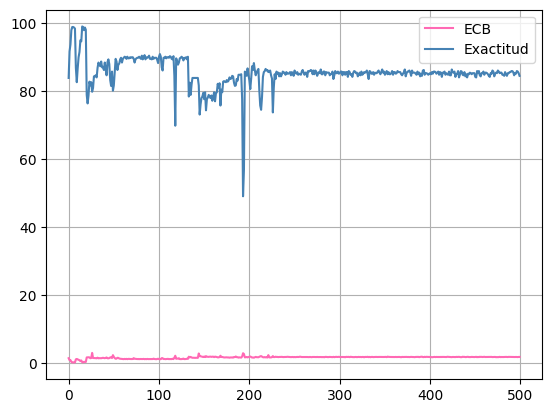

In [15]:
plt.plot(np.arange(loss.size), loss, color='hotpink', label='ECB')
plt.plot(np.arange(acc.size), acc, color='steelblue', label='Exactitud')
plt.legend()
plt.grid()
plt.show()

### Corremos solo hacia adelante para checar el conjunto de test

In [16]:
_, _, _, _, _, y_hat_test = hacia_adelante(X_test, W1, b1, W2, b2, W3, b3)
y_pred_test = np.round(y_hat_test)

print(f'Exactitud en el conjunto de prueba: {accuracy_score(y_test, y_pred_test) * 100:.2f}%')

Exactitud en el conjunto de prueba: 88.12%


### Ahora una red que tiene en sus capas ocultas funciones de activasión logística y la función de pérdida no es promediada

In [17]:
def hacia_adelante_log(X, W1, b1, W2, b2, W3, b3):
  # Nos saltamos la declaración de A1 porque sería un desperdicio
  # print(f'{X.shape = }, {W1.shape = }, {b1.shape = }')
  Z2 = X @ W1 + b1
  A2 = sigmoide(Z2)
  Z3 = A2 @ W2 + b2
  A3 = sigmoide(Z3)
  Z4 = A3 @ W3 + b3
  y_hat = sigmoide(Z4)
  return Z2, A2, Z3, A3, Z4, y_hat

In [25]:
def retropropagacion_log(X, y, alpha = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10, n_ocultas_2 = 10):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y V
  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
  # print(W1)
  b1 = np.zeros((1, n_ocultas))

  W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, n_ocultas_2)
  b2 = np.zeros((1, n_ocultas_2))

  W3 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas_2, 1)
  b3 = np.zeros((1, 1))

  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))
  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote):
      Z2, A2, Z3, A3, Z4, y_hat = hacia_adelante_log(Xlote, W1, b1, W2, b2, W3, b3)

      # cálculo de gradientes para W3 y b3 por retropropagación
      dZ4 = y_hat - ylote
      dW3 = A3.T @ dZ4
      db3 = dZ4.sum(axis=0)
      
      # cálculo de gradientes para W2 y b2 por retropropagación
      dZ3 = (dZ4 @ W3.T) * derivada_sigmoide(Z3)
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      dZ2 = (dZ3 @ W2.T) * derivada_sigmoide(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # IMPORTANTE
      # la actualización de los parámetros
      # debe hacerse de forma simultánea
      W3 -= alpha * dW3
      b3 -= alpha * db3
      W2 -= alpha * dW2
      b2 -= alpha * db2
      W1 -= alpha * dW1
      b1 -= alpha * db1


      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria(ylote, y_hat)
      exactitudes[i] += exactitud(ylote, np.round(y_hat))

    # perdidas[i] /= n_lotes
    # exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, W3, b3, perdidas, exactitudes

In [26]:
W1, b1, W2, b2, W3, b3, loss_log, acc_log = retropropagacion_log(X_train,
                                                    y_train[:, np.newaxis],
                                                    alpha=0.2, 
                                                    n_epocas=500, 
                                                    n_ocultas=10, n_ocultas_2=20, 
                                                    t_lote=4)

Epoch 0: Pérdida = 322.38218951621377 Exactitud = 11925.0
Epoch 1: Pérdida = 200.37068833267875 Exactitud = 13725.0
Epoch 2: Pérdida = 191.3715776655105 Exactitud = 13875.0
Epoch 3: Pérdida = 182.10134205591018 Exactitud = 14025.0
Epoch 4: Pérdida = 181.14810982715463 Exactitud = 14000.0
Epoch 5: Pérdida = 183.48257202795705 Exactitud = 14050.0
Epoch 6: Pérdida = 176.73527632993026 Exactitud = 14050.0
Epoch 7: Pérdida = 171.85339251885523 Exactitud = 14025.0
Epoch 8: Pérdida = 171.93698741184537 Exactitud = 14050.0
Epoch 9: Pérdida = 172.43451202191696 Exactitud = 14250.0
Epoch 10: Pérdida = 171.50280700843768 Exactitud = 14000.0
Epoch 11: Pérdida = 172.1332919133457 Exactitud = 14025.0
Epoch 12: Pérdida = 169.4494079002233 Exactitud = 13875.0
Epoch 13: Pérdida = 171.79209610617417 Exactitud = 14125.0
Epoch 14: Pérdida = 165.9599620923114 Exactitud = 13950.0
Epoch 15: Pérdida = 164.3614012927001 Exactitud = 13950.0
Epoch 16: Pérdida = 158.96866556759147 Exactitud = 14050.0
Epoch 17: Pé

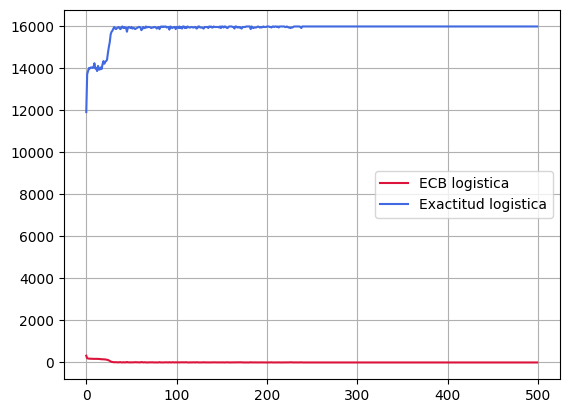

In [27]:
# plt.plot(np.arange(loss.size), loss, color='hotpink', label='ECB')
# plt.plot(np.arange(acc.size), acc, color='steelblue', label='Exactitud')

plt.plot(np.arange(loss_log.size), loss_log, color='crimson', label='ECB logistica')
plt.plot(np.arange(acc_log.size), acc_log, color='royalblue', label='Exactitud logistica')

plt.legend()
plt.grid()
plt.show()

In [28]:
_, _, _, _, _, y_hat_test = hacia_adelante_log(X_test, W1, b1, W2, b2, W3, b3)
y_pred_test = np.round(y_hat_test)

print(f'Exactitud en el conjunto de prueba: {accuracy_score(y_test, y_pred_test) * 100:.2f}%')

Exactitud en el conjunto de prueba: 100.00%


### Observaciones

Por las exactitudes podemos observar que aparentemente la que tuvo un mejor desempeño fue la Logística. Estoy asumiendo que llegó a un número tan impresionante (100) en parte porque los datos no contienen tanto ruido y a vista podemos ver que no hay un traslaple; por lo cual no se me hace tan descabellado que lograra separar tan bien los datos. 
Aunque se me hace muy importante mencionar que al correr el mismo setup, pero con la segunda capa siendo 10, el Acc estaba llegando solamente a 40%, por lo que ese hyper parámetro aparentemente tiene mucha ingerencia sobre este resultado. De igual manera creo que el hecho de que la sigmoide sea no saturada auxilió al desempeño que tuvo la red. 